In [ ]:
%pylab
%matplotlib inline
from scipy.stats import multivariate_normal
from sklearn import svm
from sklearn import preprocessing
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression

def readfile(filename, n,d):
    y = np.zeros(n) # targets
    X = np.zeros((n,d)) # input matrix each row is a sample data point
    li = 0 
    with open(filename, "rb") as f:
        for line in f:
           if li>=n : 
             break;
           parts = line.split()
           y[li] = float(parts[0])
           for i in range(len(parts)): 
                if i >0 and parts[i] != '\n': 
                    fparts = parts[i].split(":")
                    X[li,int(fparts[0])-1] = float(fparts[1])
           li = li +1
    return (y,X)
def get_data_plot(stats):
    xvals = np.array([x1 for x1, y1 in stats])
    yvals = np.array([y1 for x1, y1 in stats])
    return (xvals,yvals)


In [2]:

def least_squares(w,X,y,lambd): # computes the error value for the given parameter w
    n, d = X.shape
    pw = 0
    for i in range(n): 
        dif = np.dot(X[i,:],w) - y[i]
        pw = pw + dif*dif
    pw = pw/float(n)
    pw = pw + 0.5*lambd*np.square(np.linalg.norm(w))
    return pw
def get_grad(w,xi,yi,lambd): # computes the error value for the given parameter w
    prod = np.dot(xi,w)
    cof = 2*(prod-yi)
    return np.add(cof*xi,np.multiply(w,lambd))

In [3]:
def sgd(X,y, lambd, num_effective_passes,obj = least_squares,grad = get_grad, verbose=False):
  # each row contains a data point with dim d
  # active_stargey: case -1 (nothing), case 1 (reset the block list in each iteration), case 2 ( holding a queue with a limited size), case 3 (online random permutation replacement) 
  n, d = X.shape
  rperm = np.random.permutation(n);
  w = np.zeros(d)
  obj_value = obj(w,X,y,lambd) 
  if verbose:
    print(" Initial objective value: {}".format(obj_value))
  past_ef_pass = 0
 
  stats = [(0.0, obj_value)]
  completed_effective_passes = 0.0
  eta = 0.1 
  T = 0
  while completed_effective_passes < num_effective_passes:
    inds = rperm[np.random.permutation(n)] 
    for ii in inds:
        T = T+1
        stepsi = 0.001
        w = w - stepsi*grad(w,X[ii,:],y[ii],lambd)
    past_ef_pass = completed_effective_passes
    completed_effective_passes += len(inds) / float(n)
    obj_value = obj(w,X,y,lambd)
    stats.append((completed_effective_passes, obj_value))
    if verbose:
      print("Obj[{}]= {}".format(completed_effective_passes, obj_value))
  return (stats,w)

In [37]:
def run_small_experiment(X,y,lambd,passes,plotname,primal_accuracy = False):
    num = 4
    rep = 4
    N,d = X.shape
    n = N
    main_opt = 0
    clf = Ridge(alpha=lambd*N,fit_intercept=False)
    clf.fit(X, y)
    primal_opt =  least_squares(clf.coef_,X,y,lambd)
    print("primal obj={}".format(primal_opt))
    def dist_opt(w,X2,y2,lambd2):
        return least_squares(w,X2,y2,lambd) - primal_opt
        #delta = w - clf.coef_ 
        #return pow(np.linalg.norm(delta),2)
    (stats_n,w_n) = sgd( X, y, lambd, passes, obj = dist_opt,verbose=True)
    t_randomperm, f_randomperm = get_data_plot(stats_n)  
    converge_rate = f_randomperm
    plabel = "grad1"
    plt.plot(t_randomperm,np.log10(f_randomperm),label = plabel, marker='o')
#     inds = np.random.randint(N, size=n);
#     A = np.zeros((N,d))
#     X_sub = X[inds,:]
#     y_sub = y[inds]
    mean_vec = np.zeros(d)
    for i in range(N): 
        mean_vec = mean_vec + y[i]*X[i,:]
    mean_vec = mean_vec/float(N)
    def get_grad_2(w,xi,yi,lambd): # computes the error value for the given parameter w
        prod = np.dot(xi,w)
        cof = 2*(prod)
        return np.add(cof*xi-2*mean_vec,np.multiply(w,lambd))
    lambda_main = 1.0/float(n)
    cov_mat = np.dot(np.transpose(X),X)/float(n)
    inv_cov = np.linalg.inv(np.add(cov_mat,lambd*eye(d)))
    print(np.squeeze(np.asarray(inv_cov)))
    mu = np.dot(np.transpose(X),y)/float(n)
    #t = np.random.multivariate_normal(np.zeros(d),inv_cov,(n,d))
    #print(t.shape)
    U, s, V = np.linalg.svd(np.add(cov_mat,lambd*np.eye(d)))
    def grad_eff(w,xi,yi,lambd): 
        g = np.zeros(d)
        g = 2*np.dot(cov_mat,w)
        g = (g-2*mu)
        g = g + lambd*w # np.random.multivariate_normal(np.zeros(d),inv_cov)
        
        return g + np.random.randn()*V[:,35]
    (stats_f,w_f) =sgd( X,y, lambd, passes, obj = dist_opt,grad = grad_eff, verbose=True)
    t_randomperm, f_randomperm = get_data_plot(stats_f)  
    converge_rate = f_randomperm
    plabel = "grad2"
    plt.plot(t_randomperm,np.log10(f_randomperm),label = plabel, marker='o')
    lgd = plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
    plt.savefig(plotname, facecolor='w', edgecolor='w', orientation='portrait',  format='eps', bbox_extra_artists=(lgd,), bbox_inches='tight')

primal obj=0.448450687754
 Initial objective value: 0.551549312246
Obj[1.0]= 0.0344341516865
Obj[2.0]= 0.00241449581277
Obj[3.0]= 0.00577716764716
Obj[4.0]= 0.0019205055756
Obj[5.0]= 0.00882193448164
Obj[6.0]= 0.00697019793892
Obj[7.0]= 0.00508707675125
Obj[8.0]= 0.00330363667281
Obj[9.0]= 0.00213546650139
Obj[10.0]= 0.00425967955048
Obj[11.0]= 0.00216160674521
Obj[12.0]= 0.0022240343939
Obj[13.0]= 0.00759031367392
Obj[14.0]= 0.0106185535447
Obj[15.0]= 0.00610410569062
Obj[16.0]= 0.0050571072203
Obj[17.0]= 0.00518427714955
Obj[18.0]= 0.00286712508267
Obj[19.0]= 0.00242966287502
Obj[20.0]= 0.00433241842653
Obj[21.0]= 0.00240945126461
Obj[22.0]= 0.00250365612822
Obj[23.0]= 0.00574793550594
Obj[24.0]= 0.00341900422835
Obj[25.0]= 0.0107300100833
Obj[26.0]= 0.00409004846177
Obj[27.0]= 0.0021673254698
Obj[28.0]= 0.00601807091225
Obj[29.0]= 0.00338251027834
Obj[30.0]= 0.00530631394107
Obj[31.0]= 0.00697945753042
Obj[32.0]= 0.00371282183374
Obj[33.0]= 0.00690046315748
Obj[34.0]= 0.003859372517

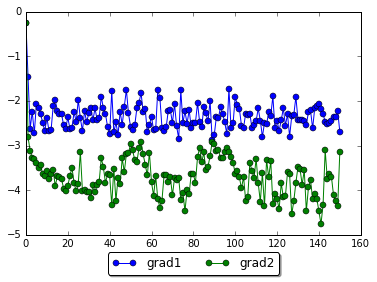

In [38]:
n = 32561; 
d = 123; 
import readsvm 
#filename = "../datasets/rcv1_train.binary"
filename = "../datasets/a9a"
y, X = readfile(filename,n,d)
# X = preprocessing.normalize(X, norm='l2')
lambd = 1.0/n
passes = 150 

#print(mean_vec.shape)
alpha = run_small_experiment(X,y, lambd,passes,"plot/gisette_scale_primal.eps",primal_accuracy =False)

primal obj=0.449438705113
 Initial objective value: 0.550561294887
Obj[1.0]= 0.123597833046,delta_alpha = -1.30347047935,sqi=1.0
Obj[2.0]= 0.418994453631,delta_alpha = 0.402793241809,sqi=1.0
Obj[3.0]= 0.0268675217216,delta_alpha = 0.321546048254,sqi=1.0
Obj[4.0]= 0.0102838153502,delta_alpha = -1.17876691827,sqi=1.0
Obj[5.0]= 0.00467602867138,delta_alpha = -0.299902394629,sqi=1.0
Obj[6.0]= 0.00975067783259,delta_alpha = -0.282833069791,sqi=1.0
Obj[7.0]= 0.00328554207086,delta_alpha = -1.24033845978,sqi=1.0
Obj[8.0]= 0.00124302913418,delta_alpha = -1.05971904085,sqi=1.0
Obj[9.0]= 0.00112687762624,delta_alpha = -0.893867026198,sqi=1.0
Obj[10.0]= 0.000313357280788,delta_alpha = 0.965700813167,sqi=1.0
 Initial objective value: 0.550561294887
Obj[1.0]= 0.0316883064541,delta_alpha = -0.420125035937,sqi=1.0
Obj[2.0]= 0.00363441241391,delta_alpha = 0.00432128097016,sqi=1.0
Obj[3.0]= 0.000485508695041,delta_alpha = 0.418919676466,sqi=1.0
Obj[4.0]= 0.000295735840037,delta_alpha = 0.141385955283,s

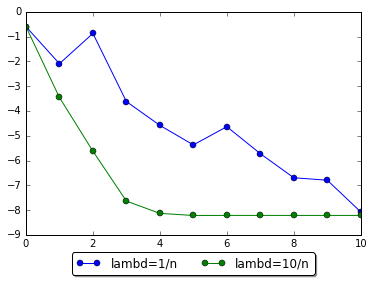

In [54]:
n = 32561; 
d = 123; 
import readsvm 

filename = "../datasets/a9a"
y, X = readfile(filename,n,d)
# X = preprocessing.normalize(X, norm='l2')
lambd = 1.0/n
passes = 10
alpha = run_small_experiment(X,y, lambd,passes,"plot/a9a_scale_dual.eps",primal_accuracy =True)

primal obj=0.0170737651357
 Initial objective value: 0.0170737651357
Obj[1.0]= 0.0170313080527,delta_alpha = 0.999964371443,sqi=4734.80287401
Obj[2.0]= 0.017006480073,delta_alpha = -0.999913197032,sqi=4651.39280976
Obj[3.0]= 0.0169869585013,delta_alpha = 1.00017086586,sqi=4635.88273367
Obj[4.0]= 0.0169695643194,delta_alpha = 0.999865451282,sqi=4601.24822789
Obj[5.0]= 0.0169539012395,delta_alpha = -1.00009775179,sqi=4607.78314123
Obj[6.0]= 0.0169394539968,delta_alpha = -1.00013875792,sqi=4627.6942918
Obj[7.0]= 0.0169254533949,delta_alpha = 1.00018855629,sqi=4607.50244305
Obj[8.0]= 0.0169123678006,delta_alpha = 1.00004256042,sqi=4668.98370134
Obj[9.0]= 0.0168995245705,delta_alpha = -1.00002302865,sqi=4624.1419285
Obj[10.0]= 0.01688725595,delta_alpha = -0.999852828069,sqi=4597.2706135
 Initial objective value: 0.0170737651357
Obj[1.0]= 0.0170203803413,delta_alpha = 0.999969026386,sqi=4711.17378456
Obj[2.0]= 0.0169896383002,delta_alpha = 0.999763231412,sqi=4640.28200306
Obj[3.0]= 0.0169651

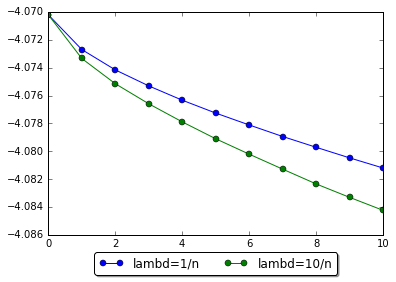

In [58]:
n = 6000; 
d = 5000; 
import readsvm 
#filename = "../datasets/rcv1_train.binary"
filename = "../datasets/gisette_scale"
y, X = readfile(filename,n,d)
#X = preprocessing.scale(X)
lambd = 1.0/n
passes = 10
run_small_experiment(X,y, lambd,passes,"plot/gisette_scale_primal.eps",primal_accuracy = False)

primal obj=0.355197469316
 Initial objective value: 0.644802530684
Obj[1.0]= 1.0766500303,delta_alpha = -0.950230479826
Obj[2.0]= 0.516334096075,delta_alpha = -1.00715338
Obj[3.0]= 0.287211251329,delta_alpha = -1.00849150022
Obj[4.0]= 0.280982671126,delta_alpha = -1.0152683149
Obj[5.0]= 0.143980870424,delta_alpha = -1.00919326435
Obj[6.0]= 0.128320140835,delta_alpha = -1.09842405614
Obj[7.0]= 0.152711470914,delta_alpha = 0.357289735372
Obj[8.0]= 0.229884108907,delta_alpha = -0.581250413636
Obj[9.0]= 0.0969574985751,delta_alpha = -0.88617595834
Obj[10.0]= 0.0890921799579,delta_alpha = -0.936202135891
Obj[11.0]= 0.123618957249,delta_alpha = -0.626027555982
Obj[12.0]= 0.0891665795626,delta_alpha = -0.930246814615
Obj[13.0]= 0.0882981391016,delta_alpha = -0.861859827862
Obj[14.0]= 0.0716663778367,delta_alpha = -1.05091294007
Obj[15.0]= 0.105303825746,delta_alpha = -1.21972533957
Obj[16.0]= 0.0329427577864,delta_alpha = -0.976387033866
Obj[17.0]= 0.0685353858544,delta_alpha = -0.40922471996

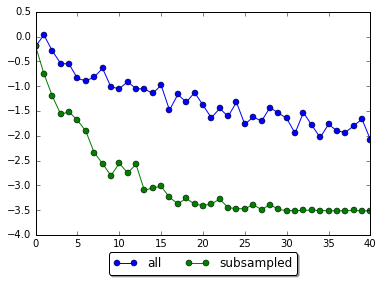

In [16]:
n = 49749; 
d = 300; 
filename = "../datasets/w8a"
y, X = readfile(filename,n,d)
A = np.zeros((n,d))
for i in range(n):
    if(y[i]==2 or y[i] == 0):
        y[i] = -1;
    A[i,:] = y[i]*X[i,:]
lambd = 1.0/n
passes = 40
run_small_experiment(X,y,lambd,passes,"plot/w8a_primal.eps",primal_accuracy = True)

primal obj=0.355197469316
 Initial objective value: 0.355197469316
Obj[1.0]= 0.218744893871,delta_alpha = -0.991644213412
Obj[2.0]= 0.183519884426,delta_alpha = -0.624484201576
Obj[3.0]= 0.158094791264,delta_alpha = -0.924367237742
Obj[4.0]= 0.13858871651,delta_alpha = -1.02120979889
Obj[5.0]= 0.123152431501,delta_alpha = -0.943130889493
Obj[6.0]= 0.110612894352,delta_alpha = 0.953753998792
Obj[7.0]= 0.0999727176649,delta_alpha = -0.652352088122
Obj[8.0]= 0.0910213017823,delta_alpha = -0.938426317515
Obj[9.0]= 0.0831951694256,delta_alpha = -0.336996396686
Obj[10.0]= 0.0764380810828,delta_alpha = -0.921730072974
Obj[11.0]= 0.0705308321697,delta_alpha = -1.13950249968
 Initial objective value: 0.355197469316
Obj[1.0]= 0.125147813148,delta_alpha = -1.30047243632
Obj[2.0]= 0.0701305234893,delta_alpha = -0.952645688558
Obj[3.0]= 0.0485764225304,delta_alpha = -1.03322229177
Obj[4.0]= 0.0361541736186,delta_alpha = -0.889357301654
Obj[5.0]= 0.029595072903,delta_alpha = -0.377586771525
Obj[6.0]

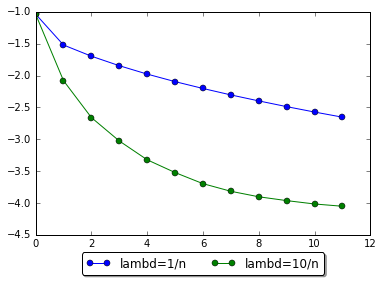

In [46]:
n = 49749; 
d = 300; 
filename = "../datasets/w8a"
y, X = readfile(filename,n,d)
# X = preprocessing.normalize(X, norm='l2')
lambd = 1.0/n
passes = 11
run_small_experiment(X,y,lambd,passes,"plot/w8a_primal.eps",primal_accuracy = False)

In [28]:
def distance_plot(X,y,n,d,lambd,nr,pivotsi,verbose = True):
    print(max(np.linalg.norm(X,axis =1 )))
    if(verbose):
        print("Loading Data Accomblished")
    indices = np.random.choice(n, pivotsi, replace=False)
    X = X[indices,:]
    y = y[indices]
    t1,t2 = X.shape
    print('t1:{},t2:{}'.format(t1,t2))
    for i in range(len(y)): 
        if y[i] == 2 :
            y[i] = -1
    n = pivotsi
    x0 = np.zeros(d)
    csize = 256
    sizes = [csize]
    while csize < (n/4.0):
        csize = 2* csize
        sizes.append(csize)
 
    clf = Ridge(alpha=lambd*n,fit_intercept=False) 
    pivot = clf.fit(X, y).coef_
    pivot_primal = primal_func(pivot,0,X,y,lambd)
    print("precision:{},pivot_norm:{}".format(primal_func(pivot,0,X,y,lambd),(np.linalg.norm(pivot))))
    spivot = str(pivot)[2:-2]
    
    dists= np.zeros((len(sizes),nr))
    angles = np.zeros((len(sizes),nr))
    for i in range(len(sizes)):
        subsamplsi = sizes[i]
        for j in range(nr):
#             print('subsample size:{}'.format(subsamplsi))
            subindices = np.random.choice(n, subsamplsi, replace=False)
            lambd_s = 1.0/subsamplsi
            clf2 = Ridge(alpha=lambd_s*n,fit_intercept=False)
            clf2.fit(X, y)
            ws = clf2.coef_
            dist = primal_func(ws,0,X,y,lambd_s) - pivot_primal
            print("======================")
            print('mu={},nu={}'.format(lambd_s,lambd))
            print('norm(wmu-wv) = {}'.format(np.linalg.norm(pivot-ws)))
            print('norm(wmu)={},norm(wv)={}'.format(np.linalg.norm(ws),np.linalg.norm(pivot)))
            dists[i,j] = abs(dist)
            print("f_mu - fv= {}".format(dists[i,j]))
        if(verbose):
          print("step: {}".format(i))   
    mdist = np.mean(dists,axis=1)
    vdist = np.var(np.log(dists),axis =1)
    print(vdist)
    sizes = np.divide(1.0,sizes)
    xd = np.log(sizes)
    yd = np.log(mdist)
    par = np.polyfit(xd, yd, 1, full=True)
    slope=par[0][0]
    intercept=par[0][1]
    xl = [min(xd), max(xd)]
    yl = [slope*xx + intercept  for xx in xl]
    mang = np.mean(angles,axis = 1)
    vang = np.var(angles,axis= 1)
    plt.errorbar(np.log(sizes),np.log(mdist),yerr=vdist)
    #plt.plot(np.log(sizes),np.log(mdist),marker='o')
    label_l = "y =%.2f x + %.2f" % (slope,intercept)
    print(label_l)
    plt.plot(xl,yl,label = label_l)
    plt.xlabel("Log(m)")
    plt.ylabel("Log(|P_m^* - P_n^*|)")
   # plt.title("Distance Plot For %s" % dataname)
    plt.legend()

10.677078252
Loading Data Accomblished
t1:49749,t2:300
precision:0.355197469316,pivot_norm:5.13170178348
mu=0.00390625,nu=2.01009065509e-05
norm(wmu-wv) = 4.21579342637
norm(wmu)=1.54606598498,norm(wv)=5.13170178348
f_mu - fv= 0.0168761820847
step: 0
mu=0.001953125,nu=2.01009065509e-05
norm(wmu-wv) = 3.76636395165
norm(wmu)=1.96409710474,norm(wv)=5.13170178348
f_mu - fv= 0.0119679260088
step: 1
mu=0.0009765625,nu=2.01009065509e-05
norm(wmu-wv) = 3.1856134041
norm(wmu)=2.50596451445,norm(wv)=5.13170178348
f_mu - fv= 0.00794231074247
step: 2
mu=0.00048828125,nu=2.01009065509e-05
norm(wmu-wv) = 2.52665574095
norm(wmu)=3.12797504459,norm(wv)=5.13170178348
f_mu - fv= 0.00483652282827
step: 3
mu=0.000244140625,nu=2.01009065509e-05
norm(wmu-wv) = 1.87363813603
norm(wmu)=3.74081446209,norm(wv)=5.13170178348
f_mu - fv= 0.00268075304756
step: 4
mu=0.0001220703125,nu=2.01009065509e-05
norm(wmu-wv) = 1.28084450665
norm(wmu)=4.26419388488,norm(wv)=5.13170178348
f_mu - fv= 0.00134092746848
step: 5
m

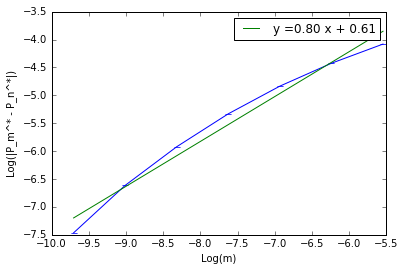

In [29]:
n = 49749; 
d = 300; 
filename = "../datasets/w8a"
y, X = readfile(filename,n,d)
#X = preprocessing.normalize(X, norm='l2')
lambd = 1.0/n
distance_plot(X,y,n,d,lambd,1,n)

3.74165738677
Loading Data Accomblished
t1:32561,t2:123
precision:0.448450687754,pivot_norm:1.40628656539
mu=0.00390625,nu=3.0711587482e-05
norm(wmu-wv) = 0.715350430069
norm(wmu)=1.03966172346,norm(wv)=1.40628656539
f_mu - fv= 0.00285437647442
step: 0
mu=0.001953125,nu=3.0711587482e-05
norm(wmu-wv) = 0.607532929037
norm(wmu)=1.10104278513,norm(wv)=1.40628656539
f_mu - fv= 0.00155789736638
step: 1
mu=0.0009765625,nu=3.0711587482e-05
norm(wmu-wv) = 0.480726780024
norm(wmu)=1.1641858363,norm(wv)=1.40628656539
f_mu - fv= 0.000835541074375
step: 2
mu=0.00048828125,nu=3.0711587482e-05
norm(wmu-wv) = 0.34431942684
norm(wmu)=1.23011952016,norm(wv)=1.40628656539
f_mu - fv= 0.000432462650813
step: 3
mu=0.000244140625,nu=3.0711587482e-05
norm(wmu-wv) = 0.216309186095
norm(wmu)=1.29356054369,norm(wv)=1.40628656539
f_mu - fv= 0.000210723396293
step: 4
mu=0.0001220703125,nu=3.0711587482e-05
norm(wmu-wv) = 0.113988122471
norm(wmu)=1.34618547197,norm(wv)=1.40628656539
f_mu - fv= 9.22841525765e-05
ste

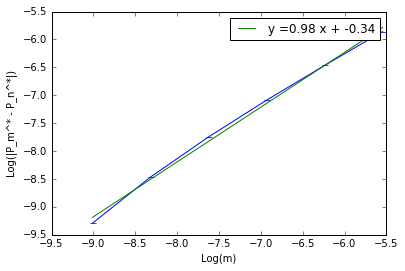

In [31]:
n = 32561; 
d = 123;
filename = "../datasets/a9a"
y, X = readfile(filename,n,d)
#X = preprocessing.normalize(X, norm='l2')
lambd = 1.0/n
distance_plot(X,y,n,d,lambd,1,n)

2.74779987078
Loading Data Accomblished
t1:50100,t2:54
precision:0.48001585772,pivot_norm:41.6857160432
mu=0.00390625,nu=1.99600798403e-05
norm(wmu-wv) = 4.59623534583
norm(wmu)=2.59330842209,norm(wv)=6.45644763343
f_mu - fv= 0.0403006214755
step: 0
mu=0.001953125,nu=1.99600798403e-05
norm(wmu-wv) = 3.81644481642
norm(wmu)=3.28725874154,norm(wv)=6.45644763343
f_mu - fv= 0.0265223458843
step: 1
mu=0.0009765625,nu=1.99600798403e-05
norm(wmu-wv) = 2.97466005977
norm(wmu)=4.0852794441,norm(wv)=6.45644763343
f_mu - fv= 0.0159554943098
step: 2
mu=0.00048828125,nu=1.99600798403e-05
norm(wmu-wv) = 2.22974864349
norm(wmu)=4.8413387952,norm(wv)=6.45644763343
f_mu - fv= 0.00877906430799
step: 3
mu=0.000244140625,nu=1.99600798403e-05
norm(wmu-wv) = 1.66623696719
norm(wmu)=5.43778595844,norm(wv)=6.45644763343
f_mu - fv= 0.00448228209424
step: 4
mu=0.0001220703125,nu=1.99600798403e-05
norm(wmu-wv) = 1.23713579299
norm(wmu)=5.8513898385,norm(wv)=6.45644763343
f_mu - fv= 0.0021244498608
step: 5
mu=6.1

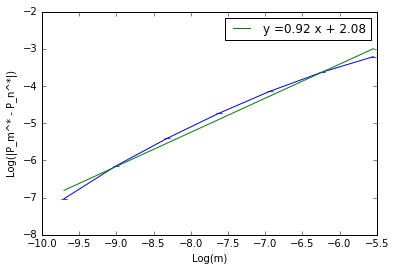

In [27]:
n = 50100; 
d = 54; 
filename = "../datasets/covtype.libsvm.binary.scale"
y, X = readfile(filename,n,d)
lambd = 1.0/n
distance_plot(X,y,n,d,lambd,1,n)

In [3]:
n = 50100; 
d = 54; 
filename = "../datasets/covtype.libsvm.binary.scale"
y, X = readfile(filename,n,d)
lambd = 1.0/(n)
U, s, V = np.linalg.svd(X, full_matrices=False)
s2 = np.power(s,2)
s = s/float(n)
s2 = s2/float(n)
s2l = s2 + lambd
d = np.divide(s,s2l)
w = np.transpose(V)*d*np.dot(np.transpose(U),y)

In [4]:
d = np.dot(np.transpose(U),y)

In [6]:
d.shape

(54,)

In [7]:
np.linalg.norm(d)

361.61233935707872

In [9]:
d

array([ -3.57333089e+02,  -3.75211473e+00,  -2.77726617e+01,
         5.66568294e+00,  -9.25529657e-01,  -1.25567469e+01,
         2.54027615e+01,  -7.44963549e+00,   1.64092573e+01,
        -9.43393334e+00,  -6.39219765e-01,  -5.64114101e+00,
        -4.47458264e+00,  -3.27368841e+00,   1.00593264e+01,
        -1.55333346e+00,  -2.13067662e+00,  -7.34605067e+00,
        -2.43610191e-01,  -5.29098730e+00,  -4.49681098e-01,
        -6.24223860e+00,  -2.28585767e+00,   1.36129698e+00,
         4.19592680e-01,   1.23001479e+00,  -8.86988827e+00,
        -6.89761661e-01,   3.73918977e+00,   6.14633253e-01,
         5.57148881e+00,  -1.44175966e+00,  -4.03229755e+00,
        -1.18225922e+00,  -2.80822029e-01,  -1.13669330e+01,
        -5.64675551e+00,   6.37583821e+00,   1.75540229e+01,
        -3.25679606e-01,  -3.77658762e+00,  -4.63365953e+00,
        -4.44494664e+00,   2.45365572e+00,   2.47918052e+00,
         2.24035513e+00,  -3.57113527e-02,  -9.92301168e-01,
         1.36176815e-01,